In [ ]:
import os
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython import display
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.image as mpimg

In [2]:
root_path = r"E:\data_share_ths\dataset\CelebAMask-HQ\CelebAMask-HQ"

img_path = root_path+"\\CelebA-HQ-img"

anno_path = root_path+"\\CelebAMask-HQ-mask-anno"

mapping_path = root_path+"\\CelebA-HQ-to-CelebA-mapping.txt"

In [3]:
import os
_anno_paths = []
_anno_ids = []
_anno_parts = []
_image_names = []

for cur_folder in os.listdir(anno_path):
    cur_path = anno_path+"\\"+cur_folder
    for img_name in os.listdir(cur_path):
        face_id,face_part  = "",""
        temps = img_name.split("_")
        if len(temps) == 2:
            face_id,face_part = temps[0],temps[1]
        else:
            face_id,face_part = temps[0],temps[1]+"_"+temps[2]
        
        _anno_paths.append(cur_path+"\\"+img_name)
        _anno_ids.append(face_id)
        _anno_parts.append(face_part.split(".")[0])
        _image_names.append(img_name)

In [4]:
dist_parts = set(_anno_parts)
print(len(dist_parts))
dist_parts

18


{'cloth',
 'ear_r',
 'eye_g',
 'hair',
 'hat',
 'l_brow',
 'l_ear',
 'l_eye',
 'l_lip',
 'mouth',
 'neck',
 'neck_l',
 'nose',
 'r_brow',
 'r_ear',
 'r_eye',
 'skin',
 'u_lip'}

In [5]:

def read_image(img_pathList):
    temp = []
    for cur_path in img_pathList:
        img = cv2.imread(cur_path)
        temp.append(img)
    return temp

In [6]:
def plotImages(image_list,image_names):
    fig = plt.figure(figsize=(12, 12))
    cols = 6
    rows = int(len(image_list)/cols)
    for i in range(0, rows*cols):
        fig.add_subplot(rows, cols, i+1).set_title(image_names[i])
        plt.axis('off')
        plt.imshow(image_list[i])
    
    plt.show()

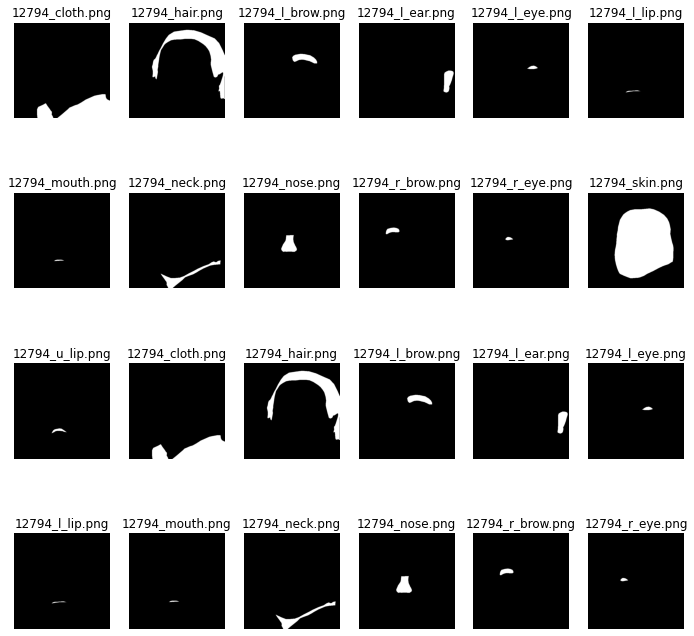

Random Id :  12794


In [7]:
random_id = random.choice(_anno_ids)
random_id_parts = []
random_names = []
while len(random_id_parts)<=18:
    for curImgname,curPath in  zip(_image_names,_anno_paths):
        if random_id in curImgname:
            random_id_parts.append(curPath)
            random_names.append(curImgname)
            continue
part_imgs = read_image(random_id_parts)

plotImages(part_imgs,random_names)
print("Random Id : ",int(random_id))

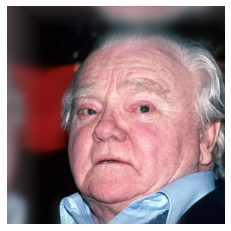

In [8]:
random_img_path = img_path+"\\"+str(int(random_id))+".jpg"
random_img = cv2.imread(random_img_path)
random_img = cv2.cvtColor(random_img,cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(random_img)

## Prepare Images

In [9]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
CHANNEL = 3

In [10]:
def read_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
    return img

In [11]:
def create_emptyImage(img_width,img_height,channel):
    img= np.zeros((img_width,img_height,channel),dtype=int)
    return img

In [12]:
def get_parts(img_id):
    _img_parts = []
    _img_paths = []
    for anno_img_id,anno_path,anno_part  in zip(_anno_ids,_anno_paths,_anno_parts):
       
        if int(anno_img_id) == img_id:
            _img_paths.append(anno_path)
            _img_parts.append(anno_part)
    return _img_parts,_img_paths

In [13]:
def read_allParts(_img_parts,_img_paths):
    """
     l_brow,r_brow,l_eye,r_eye,nose,mouth,
     u_lip,l_lip,eye_g,ear_r,l_ear,r_ear,
     neck,neck_l,cloth,skin,hair,hat
     """
    input_list = ["l_brow","r_brow","l_eye","r_eye","nose","mouth",
     "u_lip","l_lip","eye_g","ear_r","l_ear","r_ear",
     "neck","neck_l","cloth","skin","hair","hat"]
    img_list = []
    
    for cur_class in input_list:
        cur_class_imgPath = None
        for img_part,img_path in zip(_img_parts,_img_paths):
            
            if cur_class == img_part:
                cur_class_imgPath = img_path
                break
        
        if cur_class_imgPath is None:
            emptyImg = create_emptyImage(IMG_WIDTH,IMG_HEIGHT,CHANNEL)
            img_list.append(emptyImg)
        else:
            readImg = read_img(cur_class_imgPath)
            img_list.append(readImg)
        
    return img_list,input_list
        
    

In [14]:
"""
_anno_paths = []
_anno_ids = []
_anno_parts = []
_image_names = []
"""

'\n_anno_paths = []\n_anno_ids = []\n_anno_parts = []\n_image_names = []\n'

In [15]:

random_img = cv2.imread(_anno_paths[0])
empty = create_emptyImage(IMG_WIDTH,IMG_HEIGHT,CHANNEL)


2377


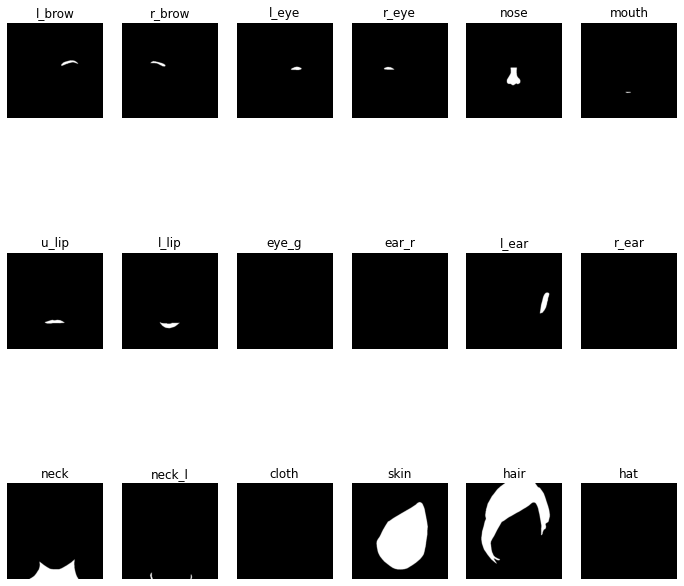

In [18]:
random_id = int(random.choice(_anno_ids))

_img_parts,_img_paths = get_parts(random_id)
img_list,parts_list = read_allParts(_img_parts,_img_paths)
print(random_id)
plotImages(img_list,parts_list)


## Create data pipeline

In [37]:
class CustomDataGen(tf.keras.utils.Sequence):
    def __init__(self,x_col,x_imgPath,batch_size, shuffle= True):

        self.x_col = x_col
        self.x_imgPath = x_imgPath
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.n = len(self.x_col)

        
    def on_epoch_end(self):
        pass
    
    
    
    
    def read_img(self,path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
        
        #convert to tf and normalize
        tf_img = tf.cast(img, tf.float32)
        tf_img = (tf_img/127.5)-1
        return tf_img
    
    def create_emptyImage(self):
        img= np.zeros((IMG_WIDTH,IMG_HEIGHT,CHANNEL),dtype=int)
        tf_img = tf.cast(img, tf.float32)
        tf_img = (tf_img/127.5)-1
        return tf_img


    def get_parts(self,img_id):
        _img_parts = []
        _img_paths = []
        for anno_img_id,anno_path,anno_part  in zip(_anno_ids,_anno_paths,_anno_parts):

            if int(anno_img_id) == img_id:
                _img_paths.append(anno_path)
                _img_parts.append(anno_part)
        return _img_parts,_img_paths

    
    def read_allParts(self,_img_parts,_img_paths):
        """
         l_brow,r_brow,l_eye,r_eye,nose,mouth,
         u_lip,l_lip,eye_g,ear_r,l_ear,r_ear,
         neck,neck_l,cloth,skin,hair,hat
         """
        input_list = ["l_brow","r_brow","l_eye","r_eye","nose","mouth",
         "u_lip","l_lip","eye_g","ear_r","l_ear","r_ear",
         "neck","neck_l","cloth","skin","hair","hat"]
        img_list = []

        for cur_class in input_list:
            cur_class_imgPath = None
            for img_part,img_path in zip(_img_parts,_img_paths):

                if cur_class == img_part:
                    cur_class_imgPath = img_path
                    break

            if cur_class_imgPath is None:
                emptyImg = create_emptyImage(IMG_WIDTH,IMG_HEIGHT,CHANNEL)
                img_list.append(emptyImg)
            else:
                readImg = read_img(cur_class_imgPath)
                img_list.append(readImg)

        return img_list,input_list

    
    
    
    def __get_input(self,imageName):

        # Read an image from a file
        real_img_path = self.x_imgPath+"\\"+imageName
        real_imgID = int(imageName.split(".")[0])
        real_image = self.read_img(real_img_path)
        
        _img_parts,_img_paths = get_parts(random_id)
        mask_img_list,parts_list = read_allParts(_img_parts,_img_paths)
        return real_image,tuple(mask_img_list)
    
    
    
    def __get_data(self,x_batches,y_batches):
        img_batches,mask_batches =  [],[]
        for x_path, y_path in zip(x_batches,y_batches):
            real_image,mask_images = self.__get_input(x_path)
            img_batches.append(real_image)
            mask_batches.append(mask_images)
        img_batches = np.asarray(img_batches)
        
        
        empty_masks = np.empty(len(mask_batches),dtype=object)
        empty_masks[:] = mask_batches
        #mask_batches = np.asarray(mask_batches)
       
        return img_batches,empty_masks
        
        
    def __getitem__(self,index):
        X_batches = self.x_col[index*self.batch_size : (index+1)*self.batch_size]

        X,Y= self.__get_data(X_batches,X_batches)
        return X,Y
    
    
    def __len__(self):
        return self.n // self.batch_size

In [38]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 200
BATCH_SIZE = 6
OUTPUT_CHANNELS = 3
EPOCHS = 150
input_list = ["l_brow","r_brow","l_eye","r_eye","nose","mouth",
 "u_lip","l_lip","eye_g","ear_r","l_ear","r_ear",
 "neck","neck_l","cloth","skin","hair","hat"]

In [39]:
img_ids = os.listdir(img_path)
print("Total image ids : ",len(img_ids))
print("Total mask ids : ",len(_anno_paths))

Total image ids :  30000
Total mask ids :  372767


In [40]:
train_ids = img_ids[:29700]
val_ids = img_ids[300:]

In [41]:
train_gen= CustomDataGen(x_col = train_ids,x_imgPath= img_path,batch_size=BATCH_SIZE)
train_gen= CustomDataGen(x_col = val_ids,x_imgPath= img_path,batch_size=BATCH_SIZE)

## Create model

{'cloth',
 'ear_r',
 'eye_g',
 'hair',
 'hat',
 'l_brow',
 'l_ear',
 'l_eye',
 'l_lip',
 'mouth',
 'neck',
 'neck_l',
 'nose',
 'r_brow',
 'r_ear',
 'r_eye',
 'skin',
 'u_lip'}

In [42]:
def downsample(filters,size,apply_batchnorm = True):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2D(filters,size,strides = 2, padding='same',
                                     kernel_initializer = initializer,use_bias =False))
    
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    
    
    return result

In [43]:
def upsample(filters,size,apply_dropout=False):
    initializer = tf.random_normal_initializer(0.,0.02)
    
    result = tf.keras.Sequential()
    
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding = 'same',
                                              kernel_initializer = initializer, use_bias = False)
              )
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    
    return result

In [44]:
def Generator():
    
    
    """
    {'cloth', 'ear_r', 'eye_g', 'hair', 'hat', 'l_brow',
     'l_ear', 'l_eye', 'l_lip', 'mouth', 'neck', 'neck_l',
     'nose', 'r_brow', 'r_ear', 'r_eye', 'skin', 'u_lip'}
     
     l_brow,r_brow,l_eye,r_eye,nose,mouth,u_lip,l_lip,eye_g,ear_r,l_ear,r_ear,neck,neck_l,cloth,skin,hair,hat
    """
    
    
        
    l_brow = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'l_brow')
    r_brow = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'r_brow')
    input1 = tf.keras.layers.concatenate([l_brow,r_brow],name = "l_r_brow")
    
    l_eye = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'l_eye')
    r_eye = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'r_eye')
    input2 = tf.keras.layers.concatenate([l_eye,r_eye],name = "l_r_eye")
    
    input12 = tf.keras.layers.concatenate([input1,input2],name = "input12")
    
    
    
    nose = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'nose')
    mouth = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'mouth')
    input3 = tf.keras.layers.concatenate([nose,mouth],name = "nose_mouth")
    
    u_lip = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'u_lip')
    l_lip = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'l_lip')
    input4 = tf.keras.layers.concatenate([u_lip,l_lip],name = "u_l_lip")
    
    input34 = tf.keras.layers.concatenate([input3,input4],name = "input34")
    
   
    eye_g = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'eye_g')
    ear_r = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'ear_r')
    input5 = tf.keras.layers.concatenate([eye_g,ear_r],name = "eye_g_ear_r")
 
    
    l_ear = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'l_ear')
    r_ear = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'r_ear')
    input6 = tf.keras.layers.concatenate([l_ear,r_ear],name = "l_r_ear")
    
    input56 = tf.keras.layers.concatenate([input5,input6],name = "input56")
    
    
    
    neck = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'neck')
    neck_l = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'neck_l')
    input7 = tf.keras.layers.concatenate([neck,neck_l],name = "neck_neck_l")
       
    cloth = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'cloth')
    skin = tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'skin')
    input8 = tf.keras.layers.concatenate([cloth,skin],name = "cloth_skin")
    
    hair =  tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'hair')
    hat =  tf.keras.layers.Input(shape = [IMG_HEIGHT,IMG_WIDTH,3], name = 'hat')
    input9 = tf.keras.layers.concatenate([hair,hat],name = "hair_hat")
    
    input789 = tf.keras.layers.concatenate([input7,input8,input9],name = "input789")
    

    inputs = tf.keras.layers.concatenate([input12,input34,input56,input789])
    
    
    down_stack = [
        downsample( 128, 4, apply_batchnorm = False), # (bs, 128,128, 64)
        downsample(256,4),  # (bs, 64, 64, 128)
        downsample(512,4),  # (bs, 32, 32, 256)
        downsample(1024,4),  # (bs, 16, 16, 512)
        downsample(1024,4),  # (bs, 8, 8, 512)
        downsample(1024,4),  # (bs, 4, 4, 512)
        downsample(1024,4),  # (bs, 2, 2, 512)
        downsample(1024,4),  # (bs, 1, 1, 512)
        
    ]
    
    
    up_stack = [
        upsample(1024,4, apply_dropout = True), # (bs, 2,2, 1024)
        upsample(1024,4, apply_dropout = True), # (bs, 4,4, 1024)
        upsample(1024,4, apply_dropout = True), # (bs, 8,8, 1024)
        upsample(1024,4), # (bs, 16,16, 1024)
        upsample(512,4), # (bs, 32, 32,input_channels 512)
        upsample(256,4), # (bs,64, 64, 256)
        upsample(128,4),  # (bs, 128, 128, 128)
    ]
    
    
    initializer = tf.random_normal_initializer(0.,0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                          strides = 2,
                                          padding = 'same',
                                          kernel_initializer = initializer,
                                          activation = 'tanh') #(bs, 256,256, 3)
    
    x = inputs
    
    
    #Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    #Upsampling and establishing the skip connections
    for up,skip in zip(up_stack,skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x,skip])
        
    x = last(x)
    
    return tf.keras.Model(inputs=[l_brow,r_brow,l_eye,r_eye,nose,mouth,u_lip,l_lip,eye_g,ear_r,l_ear,r_ear,neck,neck_l,cloth,skin,hair,hat],outputs= x)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 l_brow (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 r_brow (InputLayer)            [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 l_eye (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                          

                                                                                                  
 input12 (Concatenate)          (None, 256, 256, 12  0           ['l_r_brow[0][0]',               
                                )                                 'l_r_eye[0][0]']                
                                                                                                  
 input34 (Concatenate)          (None, 256, 256, 12  0           ['nose_mouth[0][0]',             
                                )                                 'u_l_lip[0][0]']                
                                                                                                  
 input56 (Concatenate)          (None, 256, 256, 12  0           ['eye_g_ear_r[0][0]',            
                                )                                 'l_r_ear[0][0]']                
                                                                                                  
 input789 

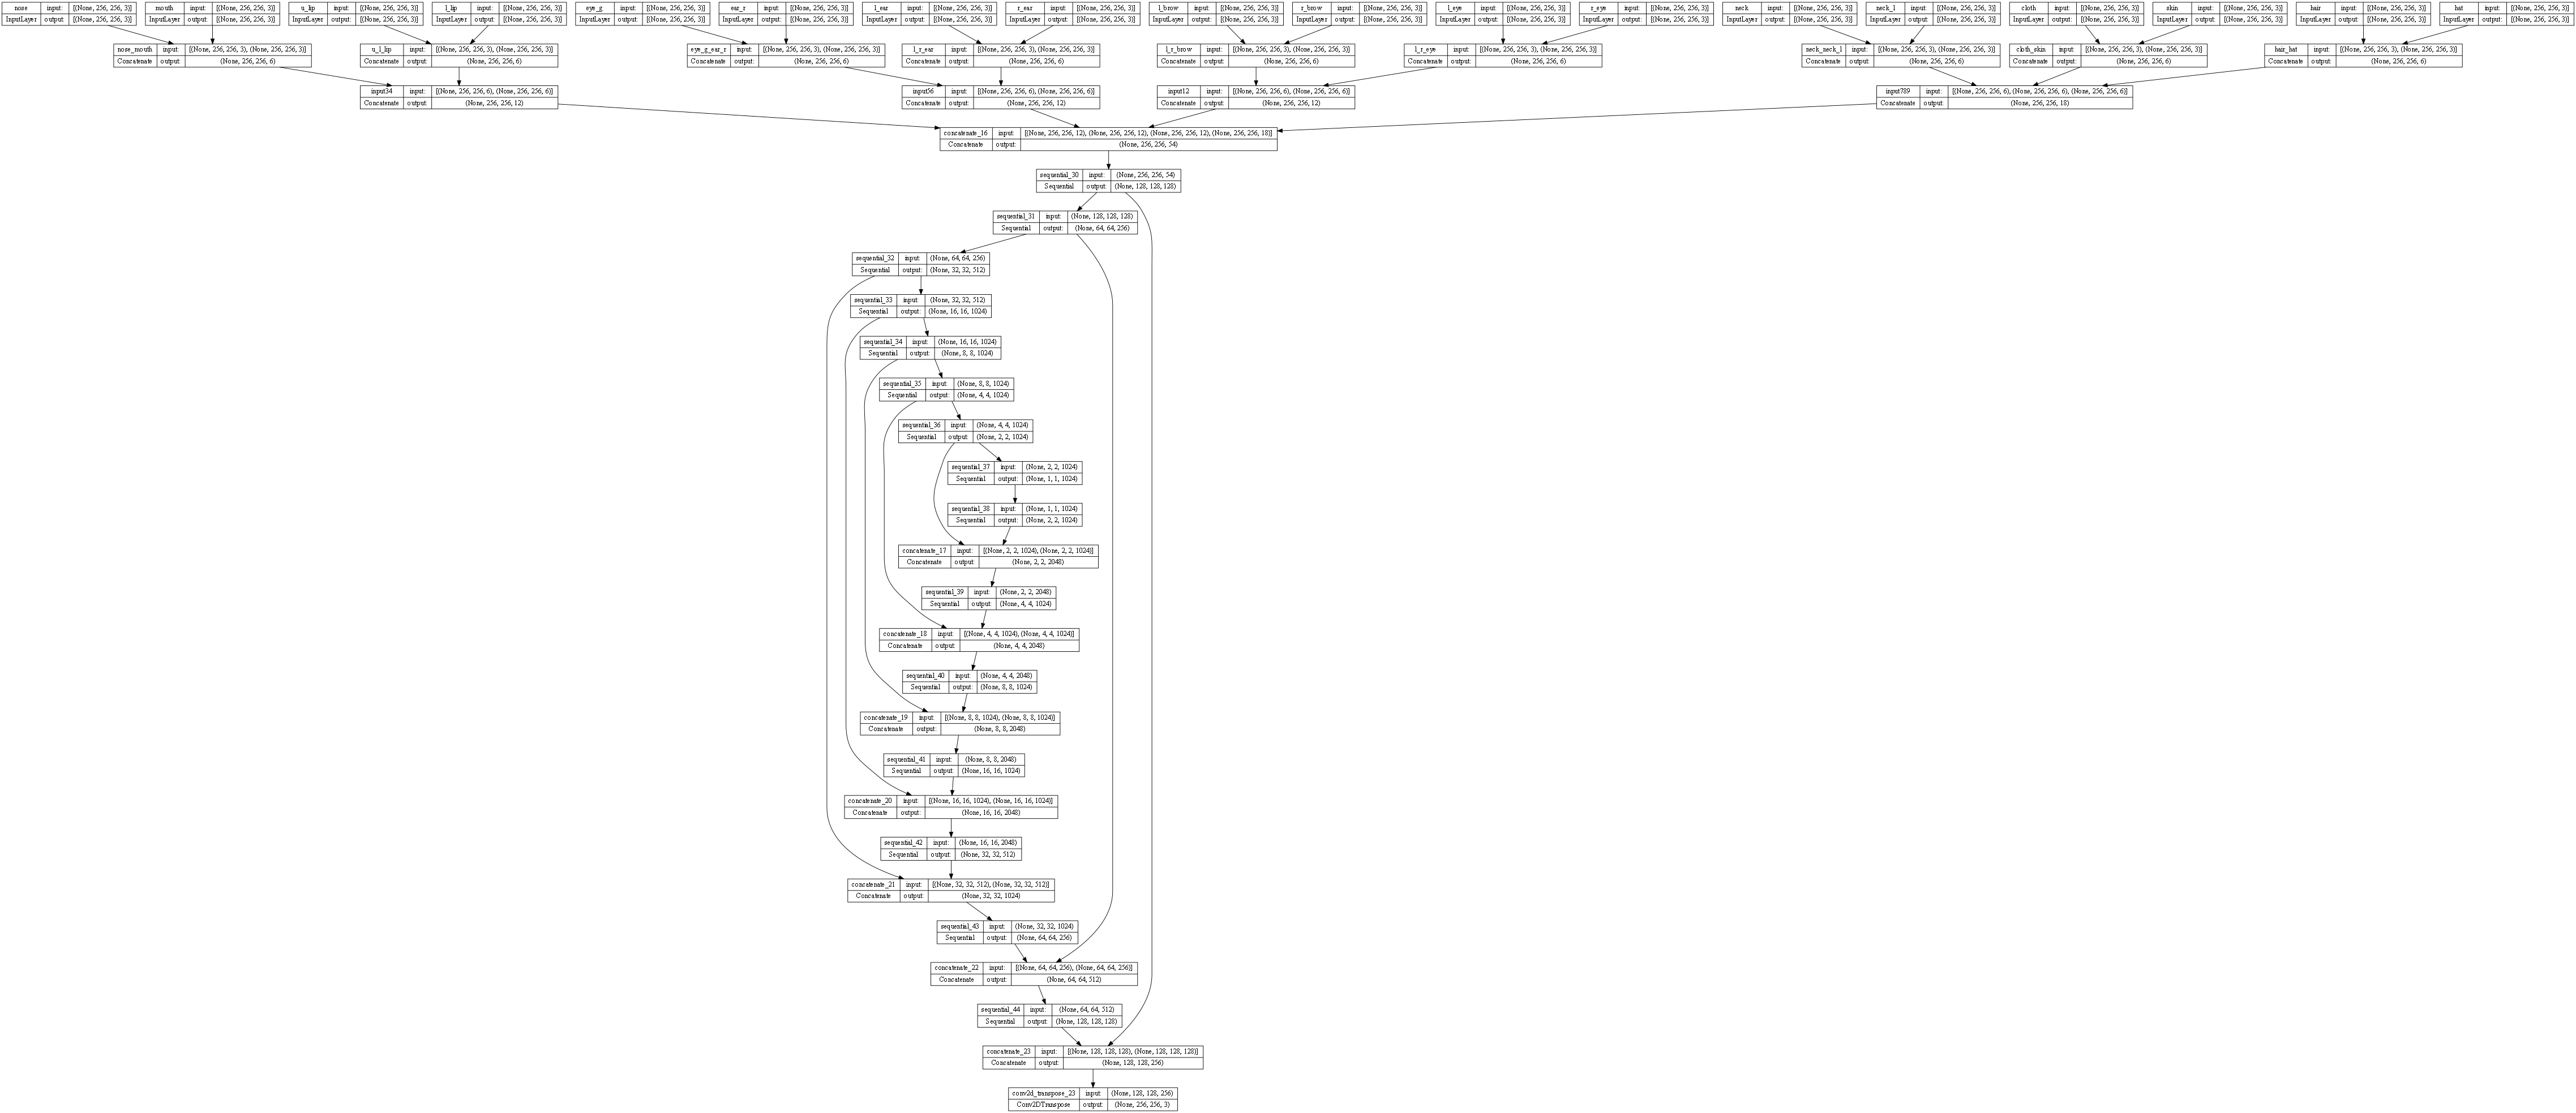

In [45]:
generator = Generator()
generator.summary()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [46]:
def generate_images(model,input_parts,tar):
    prediction = model(input_parts, training=True)
    pred_images = prediction[0]
    
    temp_parts_list = parts_list
    temp_parts_list.append("Ground Truth")
    temp_parts_list.append("Generated Image")
    temp_input_parts.append(tar)
    temp_input_parts.append(pred_images)

    plotImages(temp_input_parts,temp_parts_list)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
18


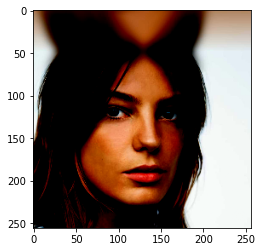

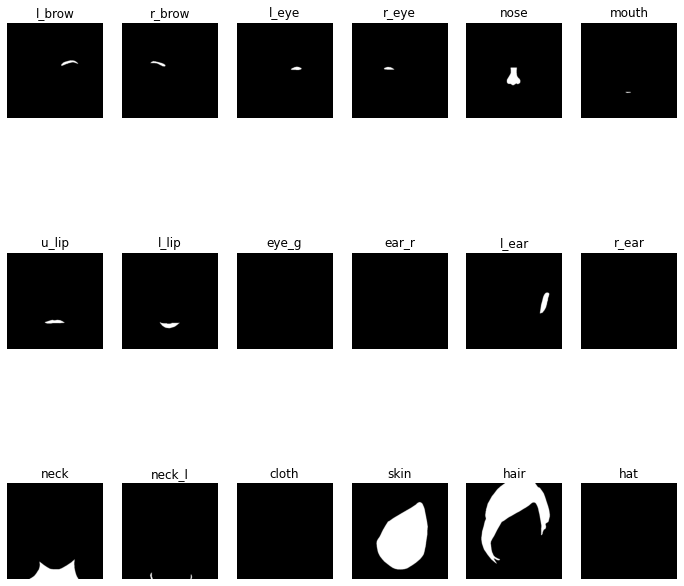

In [47]:
real_img, masks_lists  = train_gen.__getitem__(1)
test_img,test_segs = real_img[0],masks_lists[0]
print(test_img.shape)
print(len(test_segs))
plt.imshow(test_img)
plt.show()
plotImages(test_segs,parts_list)

In [56]:
#real_img,masks_lists  = train_gen.__get_input("1.jgp")
masks_lists.shape

(6,)

In [58]:
type(masks_lists[0])
print(masks_lists[0])

(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,

In [60]:
test_inputtt = tf.expand_dims(masks_lists[0], axis=0).shape.as_list()
print(test_inputtt)

masks_lists.shape

[1, 18, 256, 256, 3]


(6,)

In [50]:
print(type(masks_lists[0]))

<class 'tuple'>


In [61]:
generator(test_inputtt,training=True)

ValueError: Layer "model_2" expects 18 input(s), but it received 5 input tensors. Inputs received: [<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=18>, <tf.Tensor: shape=(), dtype=int32, numpy=256>, <tf.Tensor: shape=(), dtype=int32, numpy=256>, <tf.Tensor: shape=(), dtype=int32, numpy=3>]

In [35]:
generate_images(generator, masks_lists, real_img)

ValueError: Layer "model" expects 18 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor: shape=(6, 18, 256, 256, 3), dtype=int32, numpy=
array([[[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        ...,


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]],



       [[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        ...,


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]],



       [[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        ...,


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]],



       [[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        ...,


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]],



       [[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        ...,


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]],



       [[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        ...,


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],


        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         ...,

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],

         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]]]])>]

In [ ]:
a = [1, 2, "3", 4]
b = []
b.append(tuple(a))

In [389]:
print(b)
print(len(b))

[(1, 2, '3', 4)]
1


In [390]:
c = np.asarray(b)
print(c)

[['1' '2' '3' '4']]


In [391]:
d = np.array(b)
print(c)

[['1' '2' '3' '4']]
